In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel

In [2]:
# Create an evaluate function
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

# 1. Load Dataset:

In [4]:
# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [f'sensor_{i}' for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv('train_FD001.txt', sep=r'\s+', header=None, names=col_names)
test = pd.read_csv('test_FD001.txt', sep=r'\s+', header=None, names=col_names)
y_test = pd.read_csv('RUL_FD001.txt', sep=r'\s+', header=None, names=['RUL'])

train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


# 2. Compute RUL (Remaining Useful Life):

In [6]:
def calculate_RUL(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = train.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()

    # Merge the max cycle back into the original frame
    # "Join each row in df with the max_cycle of that unit number."
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)

    return result_frame

train = calculate_RUL(train)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


# 3. Data Preproccessing:

In [8]:
drop_sensors = ['sensor_1','sensor_5','sensor_6','sensor_10','sensor_16','sensor_18','sensor_19']
drop_labels = index_names+setting_names+drop_sensors

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')  # Removes the 'RUL' column from X_train and Returns that column's data to y_train.

X_test = test.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)

# 4. Cap Target RUL:

In [10]:
y_train_clipped = y_train.clip(upper=125)

In [11]:
all(y_train.where(y_train <= 125, 125) == y_train_clipped)

True

# 5. Prediction Using Random Forest Regression:

In [13]:
# create and fit model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = rf_model.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf_model.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:6.822772366264553, R2:0.9731948207017206
test set RMSE:18.17273974941588, R2:0.8087588837049422


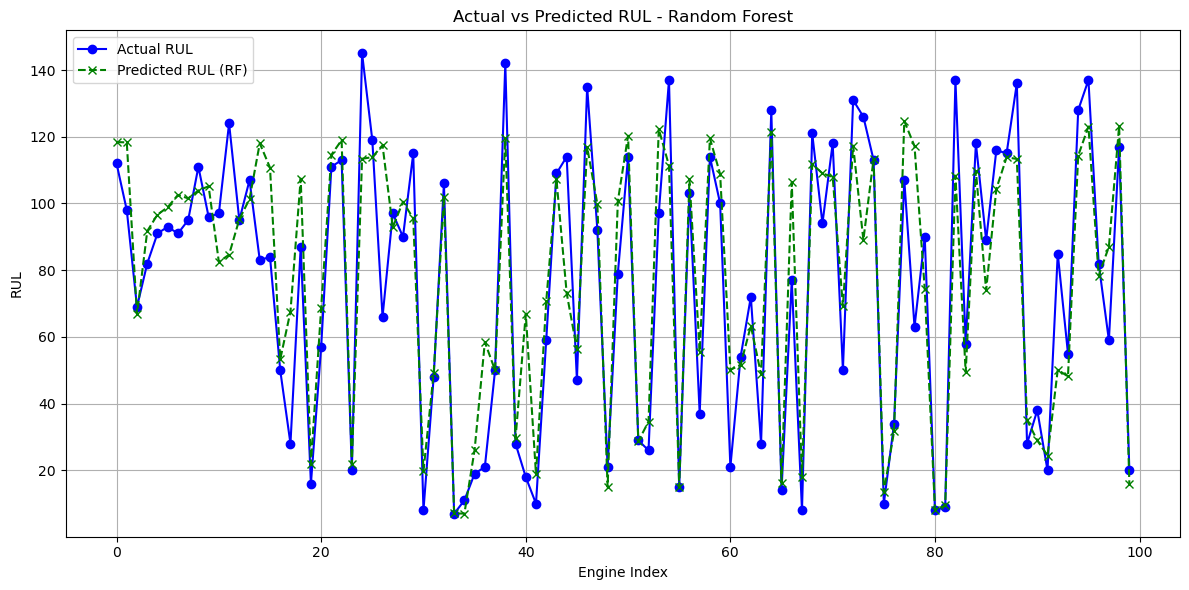

In [14]:
plt.figure(figsize=(12, 6))

plt.plot(y_test.values, label='Actual RUL', marker='o', linestyle='-', color='blue')
plt.plot(y_hat_test, label='Predicted RUL (RF)', marker='x', linestyle='--', color='green')

plt.xlabel('Engine Index')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL - Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Scaling:

In [16]:
# Scaling
# scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. Prediction Using XGBoost Regression:

In [18]:
# create and fit model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train_clipped)

# predict and evaluate
y_hat_train = xgb_model.predict(X_train_scaled)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = xgb_model.predict(X_test_scaled)
evaluate(y_test, y_hat_test)

train set RMSE:12.491212956524928, R2:0.9101524949073792
test set RMSE:18.52998071345865, R2:0.8011660575866699


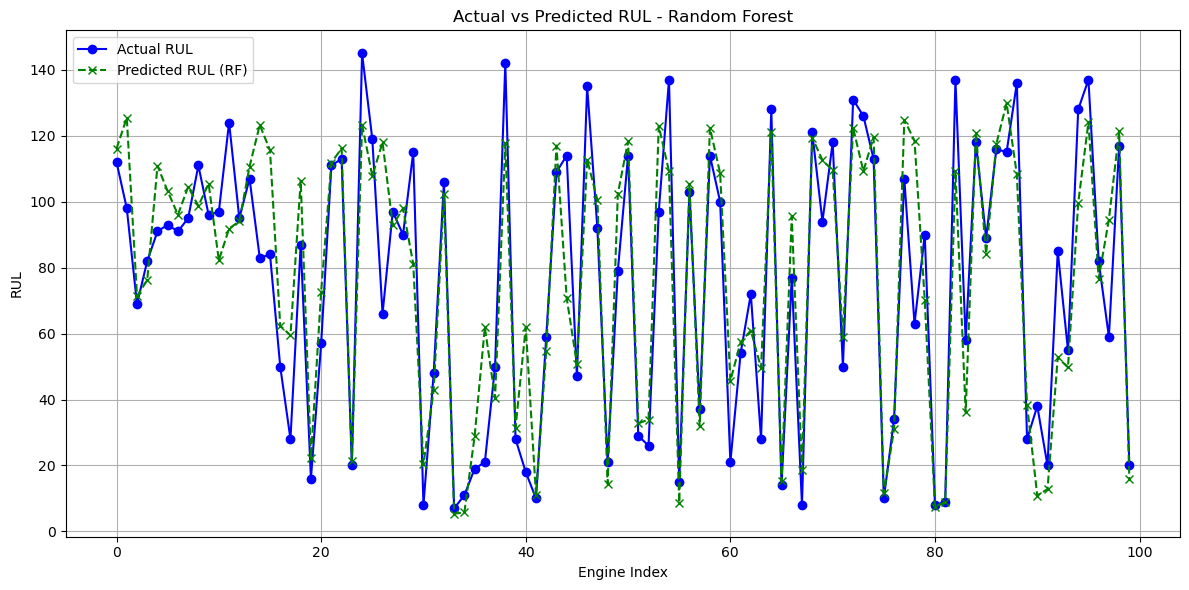

In [19]:
plt.figure(figsize=(12, 6))

plt.plot(y_test.values, label='Actual RUL', marker='o', linestyle='-', color='blue')
plt.plot(y_hat_test, label='Predicted RUL (RF)', marker='x', linestyle='--', color='green')

plt.xlabel('Engine Index')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL - Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Regularization:

In [21]:
# Improved model with regularization
xgb_improved = XGBRegressor(
    n_estimators=200,      # Increased from 100
    learning_rate=0.05,    # Lower learning rate
    max_depth=5,          # Restrict tree depth
    subsample=0.8,         # Use 80% of data for each tree
    colsample_bytree=0.8,  # Use 80% of features for each tree
    reg_alpha=1,          # L1 regularization
    reg_lambda=1,         # L2 regularization
    random_state=42
)

xgb_improved.fit(X_train_scaled, y_train_clipped)

# Evaluate
y_hat_train = xgb_improved.predict(X_train_scaled)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = xgb_improved.predict(X_test_scaled)
evaluate(y_test, y_hat_test)

train set RMSE:16.2698015999029, R2:0.8475731611251831
test set RMSE:18.00457874980803, R2:0.8122817873954773


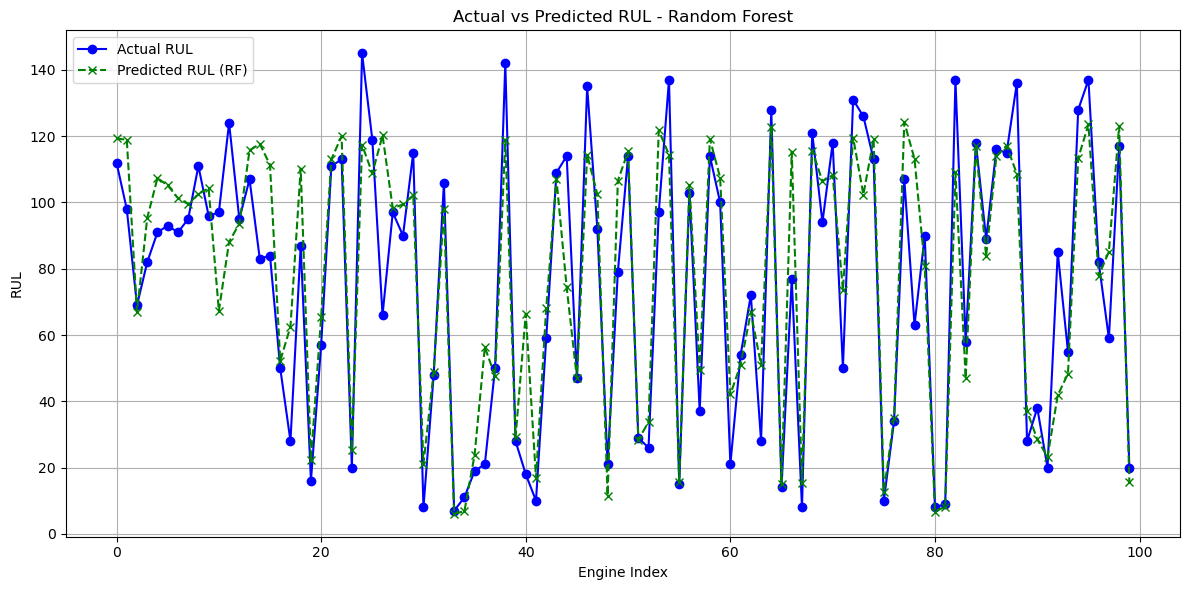

In [22]:
plt.figure(figsize=(12, 6))

plt.plot(y_test.values, label='Actual RUL', marker='o', linestyle='-', color='blue')
plt.plot(y_hat_test, label='Predicted RUL (RF)', marker='x', linestyle='--', color='green')

plt.xlabel('Engine Index')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL - Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()